# Results on 10 authors

In [18]:
import numpy as np
import os
from train import model_fn
import matplotlib.pyplot as plt
from siamese_triplet import data_to_Iterator, extract_embeddings
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier as KNC
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [19]:
data_dir = '../data/processed/'
data_name = 'top10.json'
prefix = data_name[:-5]
file_dict = prefix + '_dict.pkl'
tokenized_train_data = prefix + '_train.pkl'
tokenized_valid_data = prefix + '_valid.pkl'
tokenized_test_data = prefix + '_test.pkl'


## Load model

In [20]:
MODEL , hist = model_fn('./trained_models');

Loading model.
model_info: {'INPUT_DIM': 17866, 'WORD_EMBEDDING_DIM': 100, 'N_FILTERS': 100, 'FILTER_SIZES': [2, 3, 4], 'AUTHOR_DIM': 2, 'DROPOUT': 0.5, 'PAD_IDX': 1, 'TRAIN_HISTORY': ([450.0, 450.0, 449.8, 449.3333333333333, 448.4, 446.26666666666665, 438.3333333333333, 436.2, 427.26666666666665, 424.26666666666665, 425.53333333333336, 422.1333333333333, 420.53333333333336, 414.26666666666665, 411.73333333333335, 413.73333333333335, 411.3333333333333, 408.46666666666664, 403.93333333333334, 399.6], [415.0, 415.0, 415.0, 415.0, 415.0, 415.0, 415.0, 407.0, 412.0, 415.0, 408.0, 415.0, 412.0, 409.0, 413.0, 415.0, 415.0, 407.0, 412.0, 411.0]), 'LR': 0.004, 'MARGIN': 0.23}
Done loading model.


### Learning history

Text(0, 0.5, 'Average non-zero triplets')

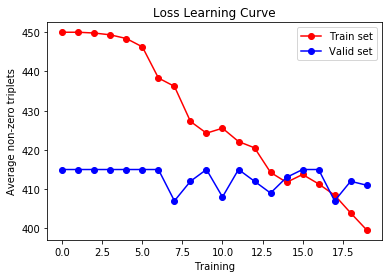

In [21]:
import matplotlib.pyplot as plt

title = 'Loss Learning Curve'
plt.title(title)
plt.plot([i for i in hist[0]], 'o-', color="r",label= "Train set")
plt.plot([i for i in hist[1]],  'o-', color="b", label="Valid set")
plt.legend(loc="best")
plt.xlabel("Training")
plt.ylabel("Average non-zero triplets")

## Extract and plot word embeddings

In [25]:

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
author_list =  ['Tennyson', 'Swinburne', 'Browning', 'Pope', 'Whitman', 'Wordsworth', 'Shakespeare', 
                'Spenser', 'Arnold', 'Shelley', 'Beowulf', 'Dryden'] 
author_dict = {i: j  for i,j in enumerate(author_list)}

classes = [author_dict[i] for i in classes]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf','#17cf84', '#1e2161']
def plot_embeddings(embeddings, targets, xlim=None, ylim=None,  save_plot= None,linewidths=2 ,legend= False,
                   figsize=(8,8),leyend_prop=18):
    plt.figure(figsize=(figsize))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=1,linewidths=linewidths , color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    if legend: plt.legend(classes, prop={'size': leyend_prop} )
    plt.tick_params(axis='both', labelsize=20)
    if save_plot!=None:
        plt.savefig('../media/'+save_plot)

In [26]:
# Create data iterators
train_Loader = data_to_Iterator(data_dir,tokenized_train_data, False)
valid_Loader = data_to_Iterator(data_dir,tokenized_valid_data, False)
test_Loader = data_to_Iterator(data_dir,tokenized_test_data,False)

In [27]:
# Extract authorcoder embeddings
train_emb, train_labels = extract_embeddings(train_Loader, MODEL, 2)
valid_emb, valid_labels = extract_embeddings(valid_Loader, MODEL, 2)
test_emb, test_labels = extract_embeddings(test_Loader, MODEL, 2)

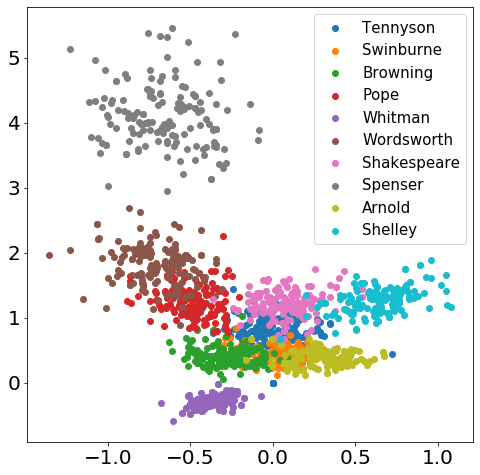

In [28]:
plot_embeddings(train_emb, train_labels, save_plot='training.png', linewidths=1, legend= True, leyend_prop=15)

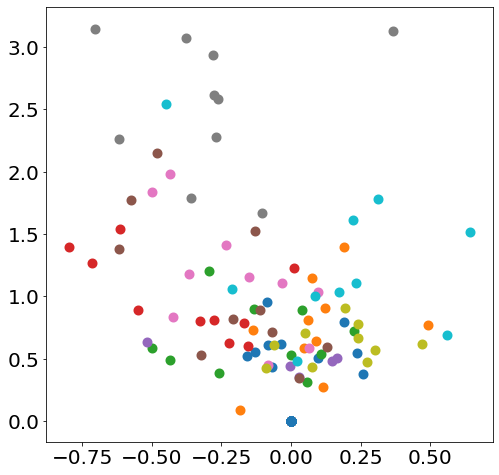

In [29]:
#plot_embeddings(train_embeddings_otl, train_labels_otl, save_plot='training.png', legend= True, leyend_prop=15,figsize=(8,8))
plot_embeddings(valid_emb, valid_labels,save_plot='valid.png',linewidths=4, figsize=(8,8))

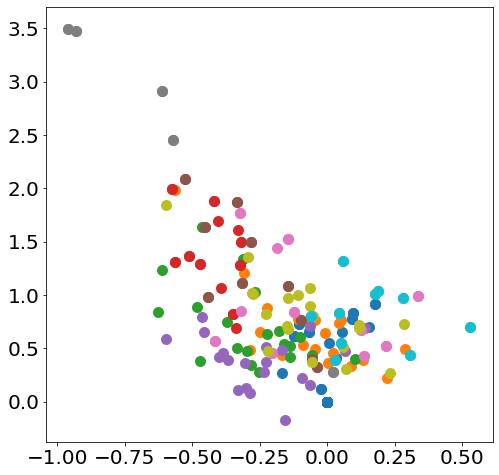

In [30]:
plot_embeddings(test_emb, test_labels,save_plot='testing.png',linewidths=5)

## Nearest neighboors classification

Text(0, 0.5, 'Classification acc')

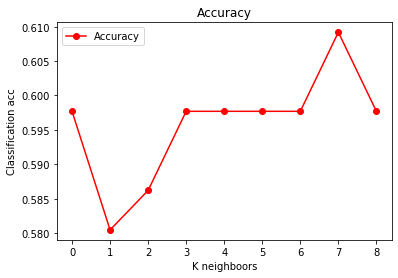

In [31]:
acc =[]
for i in range(1,10):
    KNN = KNC(n_neighbors=i)
    KNN.fit(train_emb, train_labels)
    acc.append(KNN.score(valid_emb,valid_labels))
    
    
title = 'Accuracy'
plt.title(title)
plt.plot(acc, 'o-', color="r",label= "Accuracy")
plt.legend(loc="best")
plt.xlabel("K neighboors")
plt.ylabel("Classification acc")

In [32]:
KNN = KNC(n_neighbors=3)
KNN.fit(train_emb, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

## Accuracy on poems differnt from training and validation set

In [33]:
KNN.score(test_emb,test_labels)

0.5223880597014925

### Confusion matrix

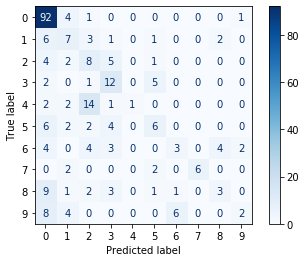

In [34]:

preds  = KNN.predict(test_emb)

cm = multilabel_confusion_matrix(test_labels,preds)
plot_confusion_matrix(KNN, test_emb,test_labels,
                                 display_labels=[0,1,2,3,4,5,6,7,8,9],
                                 cmap=plt.cm.Blues)

## Is authorencoder really an encoder?

To test is authoencoder can really encode other authors, let us look at ten different 
authors



In [35]:
new_authors = ['anonymous', 'john_dryden', 'john_ashbery', 'henry_wadsworth_longfellow', 'john_donne', 'john_koethe', 'robert_pinsky', 'lord_ron_george_gordon_', 'anne_bradstreet', 'derek_walcott'];
tokenized_train_data_ = 'top20_10_train.pkl'
tokenized_valid_data_ = 'top20_10_valid.pkl'
tokenized_test_data_ = 'top20_10_test.pkl'

train_Loader_ = data_to_Iterator(data_dir,tokenized_train_data_)
valid_Loader_ = data_to_Iterator(data_dir,tokenized_valid_data_)
test_Loader_ = data_to_Iterator(data_dir,tokenized_test_data_)

other_train_emb, other_train_labels = extract_embeddings(train_Loader_, MODEL, 2)
other_valid_emb, other_valid_labels = extract_embeddings(valid_Loader_, MODEL, 2)
#other_test_emb, other_test_labels = extract_embeddings(test_Loader_, MODEL, 2)


### Remarkable the embedding still tend to close different authors.

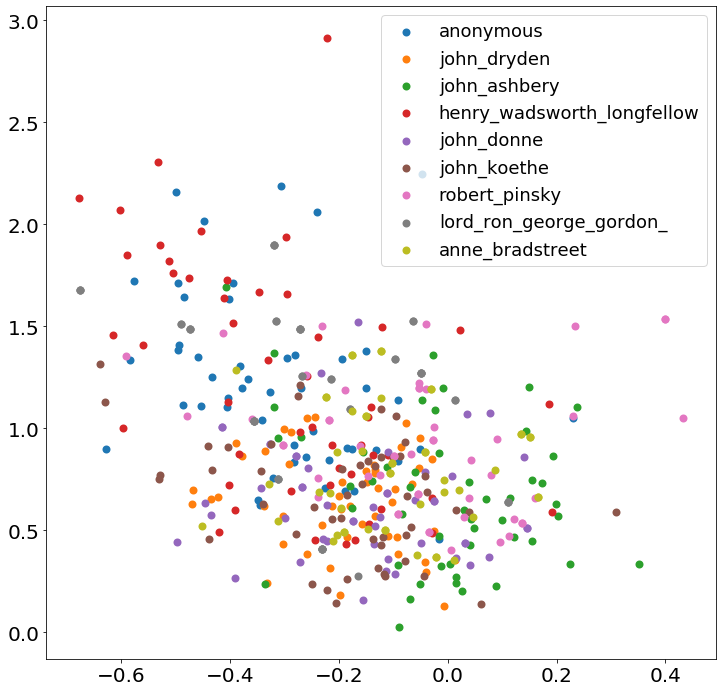

In [36]:
def plot_embeddings(embeddings, targets, xlim=None, ylim=None,  save_plot= None,linewidths=2 ,legend= False,
                   figsize=(12,12),leyend_prop=18):
    plt.figure(figsize=(figsize))
    for i in range (11,20):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=1,linewidths=linewidths )
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    if legend: plt.legend(new_authors, prop={'size': leyend_prop} )
    plt.tick_params(axis='both', labelsize=20)
    if save_plot!=None:
        plt.savefig('../media/'+save_plot)
        
plot_embeddings(other_train_emb, other_train_labels, save_plot='training_newauthors.png', linewidths=2, legend=True)

### Even more surprisingly this cluster give rise to a much better classifier than 1/10

In [37]:
KNN = KNC(n_neighbors=3)
KNN.fit(other_train_emb, other_train_labels)
KNN.score(other_valid_emb, other_valid_labels)

0.29707112970711297